In [1]:
import argparse
import os
import torch
import torch.backends.cudnn as cudnn

from network.TorchUtils import TorchModel
from features_loader import FeaturesLoaderVal, FeaturesLoader, FeaturesLoaderTrain
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from os import path
import numpy as np
from scipy import spatial

def get_centroids(model, data_iter, verbose):
    
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")
    
    normal_embed = None
    anomaly_embed = None
    
    n_normal = 0
    n_anomaly = 0

    with torch.no_grad():
        if verbose:
            data_gen = tqdm(data_iter)
        else:
            data_gen = data_iter
        for features, labels in tqdm(data_iter):
            # features is a batch where each item is a tensor of 32 4096D features
            features = features.to(device)
            labels = labels#.squeeze()
            
            outputs = model(features)  # (batch_size, 32, embed_size)
        
            embed = outputs.mean(1).cpu().numpy()
            y_true = labels.cpu().numpy()
            
            if (y_true == 0).sum():
                if normal_embed is None and (y_true == 0).sum():
                    normal_embed = embed[y_true == 0].mean(0)
                else:
                    normal_embed += embed[y_true == 0].mean(0)
                
            if (y_true == 1).sum():
                if anomaly_embed is None:
                    anomaly_embed = embed[y_true == 1].mean(0)
                else:
                    anomaly_embed += embed[y_true == 1].mean(0)

            n_normal += (y_true == 0).sum()
            n_anomaly += (y_true == 1).sum()
            
            torch.cuda.empty_cache()

    centroids = np.array([normal_embed/n_normal, anomaly_embed/n_anomaly]) 
    return centroids
    

def compute_roc_auc(features_path, annotation_path, train_features_path, train_annotation_path,
                    model_path, calc_mode, filename = '', verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")

    data_loader = FeaturesLoaderVal(features_path=features_path,
                                    annotation_path=annotation_path)

    data_iter = torch.utils.data.DataLoader(data_loader,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=0,  # 4, # change this part accordingly
                                            pin_memory=True)
    
    
    train_data_loader = FeaturesLoaderTrain(features_path=train_features_path,
                                            annotation_path=train_annotation_path)

    train_data_iter = torch.utils.data.DataLoader(train_data_loader,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=0,  # 4, # change this part accordingly
                                            pin_memory=True)

    model = TorchModel.load_model(model_path).to(device).eval()

    # enable cudnn tune
    cudnn.benchmark = True


    y_trues = torch.tensor([])
    y_preds = torch.tensor([])
    
    if calc_mode == 'triplet_centroid':
        centroids = get_centroids(model, train_data_iter, verbose)

    with torch.no_grad():
        if verbose:
            data_gen = tqdm(data_iter)
        else:
            data_gen = data_iter
        for features, start_end_couples, lengths in data_gen:
            # features is a batch where each item is a tensor of 32 4096D features
            features = features.to(device)
            if calc_mode == 'mil':
                outputs = model(features).squeeze(-1)  # (batch_size, 32)
            else: # in case of Triplet loss
                outputs = model(features)  # (batch_size, 32, embed_size)
            for vid_len, couples, output in zip(lengths, start_end_couples, outputs.cpu().numpy()):
                y_true = np.zeros(vid_len)
                y_pred = np.zeros(vid_len)

                segments_len = vid_len // 32
                for couple in couples:
                    if couple[0] != -1:
                        y_true[couple[0]: couple[1]] = 1

                for i in range(32):
                    segment_start_frame = i * segments_len
                    segment_end_frame = (i + 1) * segments_len
                    if calc_mode == 'triplet_centroid':
                        y_pred[segment_start_frame: segment_end_frame] = ((output[i] - centroids[0])**2).sum(-1)
                    elif calc_mode == 'triplet':
                        y_pred[segment_start_frame: segment_end_frame] = ((output[i] - output[0])**2).sum(-1)
                    else: # default MIL calculation
                        y_pred[segment_start_frame: segment_end_frame] = output[i]

                if y_trues is None:
                    y_trues = y_true
                    y_preds = y_pred
                else:
                    y_trues = np.concatenate([y_trues, y_true])
                    y_preds = np.concatenate([y_preds, y_pred])

    fpr, tpr, thresholds = roc_curve(y_true=y_trues, y_score=y_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    if verbose:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        if len(filename):
            os.makedirs('graphs', exist_ok=True)
            plt.savefig(path.join('graphs', filename))
            plt.close()
            print('ROC curve (area = %0.3f)' % roc_auc)
        else:
            plt.show()
            print('ROC curve (area = %0.3f)' % roc_auc)
    return roc_auc

In [3]:
features_path = './data/anomaly_features'
annotation_path = "Test_Annotation.txt"
model_path = "exps/grid_search/triplet_adadelta_0.1_8e-05_3_5_0.2/42/models/epoch_19.pt"
calc_mode = "triplet_centroid"
train_features_path = 'data/anomaly_features'
train_annotation_path = "Train_Annotation.txt"
filename = "roc_auc.png"

100%|██████████| 290/290 [00:54<00:00,  5.31it/s]


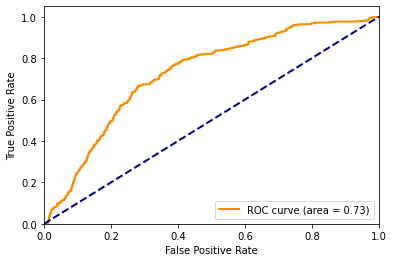

ROC curve (area = 0.725)


0.7250870223224508

In [3]:
compute_roc_auc(features_path, annotation_path, train_features_path, train_annotation_path,
                model_path, calc_mode)

In [4]:
import pandas as pd

res_df_triplet = pd.read_csv('../res_df_triplet.csv', header=0, index_col=0).reset_index(drop=True)

In [5]:
for col in res_df_triplet.columns[2:]:
    print(res_df_triplet[[col]].max())

roc_auc_epoch_0    0.706±0.000
dtype: object
roc_auc_epoch_1    0.707±0.000
dtype: object
roc_auc_epoch_2    0.705±0.000
dtype: object
roc_auc_epoch_3    0.707±0.000
dtype: object
roc_auc_epoch_4    0.705±0.000
dtype: object
roc_auc_epoch_5    0.709±0.000
dtype: object
roc_auc_epoch_6    0.706±0.000
dtype: object
roc_auc_epoch_7    0.715±0.000
dtype: object
roc_auc_epoch_8    0.706±0.000
dtype: object
roc_auc_epoch_9    0.709±0.000
dtype: object


In [6]:
res_df_triplet[res_df_triplet['roc_auc_epoch_7'] == '0.715±0.000']

params calc_mode roc_auc_epoch_0 roc_auc_epoch_1  \
32  triplet_adam_0.5_8e-05_3_3_0.02   triplet     0.691±0.000     0.554±0.000   

   roc_auc_epoch_2 roc_auc_epoch_3 roc_auc_epoch_4 roc_auc_epoch_5  \
32     0.665±0.000     0.628±0.000     0.571±0.000     0.574±0.000   

   roc_auc_epoch_6 roc_auc_epoch_7 roc_auc_epoch_8 roc_auc_epoch_9  
32     0.634±0.000     0.715±0.000     0.618±0.000     0.655±0.000

In [7]:
res_df_triplet_centroid = pd.read_csv('../res_df_triplet_centroid.csv', header=0, index_col=0).reset_index(drop=True)

In [8]:
for col in res_df_triplet_centroid.columns[2:]:
    print(res_df_triplet_centroid[[col]].max())

roc_auc_epoch_0    0.715±0.000
dtype: object
roc_auc_epoch_1    0.724±0.000
dtype: object
roc_auc_epoch_2    0.715±0.000
dtype: object
roc_auc_epoch_3    0.707±0.000
dtype: object
roc_auc_epoch_4    0.725±0.000
dtype: object
roc_auc_epoch_5    0.708±0.000
dtype: object
roc_auc_epoch_6    0.710±0.000
dtype: object
roc_auc_epoch_7    0.718±0.000
dtype: object
roc_auc_epoch_8    0.712±0.000
dtype: object
roc_auc_epoch_9    0.717±0.000
dtype: object


In [9]:
res_df_triplet_centroid[res_df_triplet_centroid['roc_auc_epoch_4'] == '0.725±0.000']

params         calc_mode roc_auc_epoch_0  \
1   triplet_adadelta_0.1_8e-05_3_3_0.02  triplet_centroid     0.715±0.000   
3    triplet_adadelta_0.1_8e-05_3_3_0.2  triplet_centroid     0.715±0.000   
5   triplet_adadelta_0.1_8e-05_3_5_0.02  triplet_centroid     0.715±0.000   
7    triplet_adadelta_0.1_8e-05_3_5_0.2  triplet_centroid     0.715±0.000   
9   triplet_adadelta_0.1_8e-05_5_3_0.02  triplet_centroid     0.715±0.000   
11   triplet_adadelta_0.1_8e-05_5_3_0.2  triplet_centroid     0.715±0.000   
13  triplet_adadelta_0.1_8e-05_5_5_0.02  triplet_centroid     0.715±0.000   
15   triplet_adadelta_0.1_8e-05_5_5_0.2  triplet_centroid     0.715±0.000   

   roc_auc_epoch_1 roc_auc_epoch_2 roc_auc_epoch_3 roc_auc_epoch_4  \
1      0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
3      0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
5      0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
7      0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
9      0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
11     0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
13     0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   
15     0.721±0.000     0.711±0.000     0.707±0.000     0.725±0.000   

   roc_auc_epoch_5 roc_auc_epoch_6 roc_auc_epoch_7 roc_auc_epoch_8  \
1      0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
3      0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
5      0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
7      0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
9      0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
11     0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
13     0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   
15     0.708±0.000     0.710±0.000     0.718±0.000     0.712±0.000   

   roc_auc_epoch_9  
1      0.717±0.000  
3      0.717±0.000  
5      0.717±0.000  
7      0.717±0.000  
9      0.717±0.000  
11     0.717±0.000  
13     0.717±0.000  
15     0.717±0.000

In [10]:
res_df_triplet_centroid[res_df_triplet_centroid['roc_auc_epoch_1'] == '0.724±0.000']

params         calc_mode roc_auc_epoch_0  \
33  triplet_adadelta_0.5_8e-05_3_3_0.02  triplet_centroid     0.712±0.000   
35   triplet_adadelta_0.5_8e-05_3_3_0.2  triplet_centroid     0.712±0.000   
37  triplet_adadelta_0.5_8e-05_3_5_0.02  triplet_centroid     0.712±0.000   
39   triplet_adadelta_0.5_8e-05_3_5_0.2  triplet_centroid     0.712±0.000   
41  triplet_adadelta_0.5_8e-05_5_3_0.02  triplet_centroid     0.712±0.000   
43   triplet_adadelta_0.5_8e-05_5_3_0.2  triplet_centroid     0.712±0.000   
45  triplet_adadelta_0.5_8e-05_5_5_0.02  triplet_centroid     0.712±0.000   
47   triplet_adadelta_0.5_8e-05_5_5_0.2  triplet_centroid     0.712±0.000   

   roc_auc_epoch_1 roc_auc_epoch_2 roc_auc_epoch_3 roc_auc_epoch_4  \
33     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
35     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
37     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
39     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
41     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
43     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
45     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   
47     0.724±0.000     0.709±0.000     0.706±0.000     0.718±0.000   

   roc_auc_epoch_5 roc_auc_epoch_6 roc_auc_epoch_7 roc_auc_epoch_8  \
33     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
35     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
37     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
39     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
41     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
43     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
45     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   
47     0.701±0.000     0.699±0.000     0.715±0.000     0.709±0.000   

   roc_auc_epoch_9  
33     0.710±0.000  
35     0.710±0.000  
37     0.710±0.000  
39     0.710±0.000  
41     0.710±0.000  
43     0.710±0.000  
45     0.710±0.000  
47     0.710±0.000

In [13]:
def row_max(x):
    return np.max([float(y.split('±')[0]) for y in x.values[2:]])

idx = res_df_triplet.agg(row_max, axis='columns').argsort()[-5:].values
res_df_triplet_final = res_df_triplet.iloc[idx]

In [14]:
idx2 = res_df_triplet_centroid.agg(row_max, axis='columns').argsort()[-10:].values
res_df_triplet_centroid_final = res_df_triplet_centroid.iloc[idx2]

In [25]:
dfs = []
for row in res_df_triplet_final.iterrows():
    params = row[1]['params']
    epoch = row[1][2:][row[1][2:] == row[1][2:].max()].keys()[0].split('_')[-1]
    df = pd.DataFrame({'Loss Func.': ['triplet loss'],
                       'Inference Mode': ['base'],
                       'Optimizer': [params.split('_')[1].capitalize()],
                       'Dropout Rate': [params.split('_')[2]],
                       'Lambdas': [params.split('_')[3]],
                       'Num. Anomaly Seg.': [params.split('_')[4]],
                       'Num. Normal Seg.': [params.split('_')[5]],
                       'Margin': [params.split('_')[6]],
                       'Best Epoch': [epoch],
                       'ROC-AUC': [row[1][2:].max()],})
    dfs.append(df)
    
res_df_triplet_centroid_final = res_df_triplet_centroid_final.loc[[33,47,3,1,13]]

for row in res_df_triplet_centroid_final.iterrows():
    params = row[1]['params']
    epoch = row[1][2:][row[1][2:] == row[1][2:].max()].keys()[0].split('_')[-1]
    df = pd.DataFrame({'Loss Func.': ['triplet loss'],
                       'Inference Mode': ['centroid'],
                       'Optimizer': [params.split('_')[1].capitalize()],
                       'Dropout Rate': [params.split('_')[2]],
                       'Lambdas': [params.split('_')[3]],
                       'Num. Anomaly Seg.': [params.split('_')[4]],
                       'Num. Normal Seg.': [params.split('_')[5]],
                       'Margin': [params.split('_')[6]],
                       'Best Epoch': [epoch],
                       'ROC-AUC': [row[1][2:].max()],})
    dfs.append(df)

In [31]:
final_res = pd.concat(dfs).reset_index(drop=True)
final_res=final_res[final_res.columns[1:]]
final_res

Inference Mode Optimizer Dropout Rate Lambdas Num. Anomaly Seg.  \
0           base      Adam          0.1   0.008                 5   
1           base      Adam          0.1   8e-05                 3   
2           base      Adam          0.5   8e-05                 3   
3           base      Adam          0.1   0.008                 3   
4           base      Adam          0.5   8e-05                 3   
5       centroid  Adadelta          0.5   8e-05                 3   
6       centroid  Adadelta          0.5   8e-05                 5   
7       centroid  Adadelta          0.1   8e-05                 3   
8       centroid  Adadelta          0.1   8e-05                 3   
9       centroid  Adadelta          0.1   8e-05                 5   

  Num. Normal Seg. Margin Best Epoch      ROC-AUC  
0                5    0.2          3  0.707±0.000  
1                3    0.2          1  0.707±0.000  
2                3    0.2          5  0.709±0.000  
3                3    0.2          9  0.709±0.000  
4                3   0.02          7  0.715±0.000  
5                3   0.02          1  0.724±0.000  
6                5    0.2          1  0.724±0.000  
7                3    0.2          4  0.725±0.000  
8                3   0.02          4  0.725±0.000  
9                5   0.02          4  0.725±0.000

In [32]:
print(str(final_res.to_latex(index=False)).replace('±', '$\pm$'))

\begin{tabular}{lllllllll}
\toprule
Inference Mode & Optimizer & Dropout Rate & Lambdas & Num. Anomaly Seg. & Num. Normal Seg. & Margin & Best Epoch &     ROC-AUC \\
\midrule
          base &      Adam &          0.1 &   0.008 &                 5 &                5 &    0.2 &          3 & 0.707$\pm$0.000 \\
          base &      Adam &          0.1 &   8e-05 &                 3 &                3 &    0.2 &          1 & 0.707$\pm$0.000 \\
          base &      Adam &          0.5 &   8e-05 &                 3 &                3 &    0.2 &          5 & 0.709$\pm$0.000 \\
          base &      Adam &          0.1 &   0.008 &                 3 &                3 &    0.2 &          9 & 0.709$\pm$0.000 \\
          base &      Adam &          0.5 &   8e-05 &                 3 &                3 &   0.02 &          7 & 0.715$\pm$0.000 \\
      centroid &  Adadelta &          0.5 &   8e-05 &                 3 &                3 &   0.02 &          1 & 0.724$\pm$0.000 \\
      centroid &  Ada

In [43]:
import pandas as pd


res = pd.DataFrame({'Algorithm': ['baseline', 'sampling strategy 2', 'sampling strategy 2',
                                  'hard miner', 'hard miner', 'hard miner',
                                  'SimCLR'], 
                    'Loss Function': ['MIL loss', 'Triplet loss', 'Triplet loss', 
                                      'Triplet loss', 'Circle loss', 'Arc-Face loss',
                                      'SimCLR loss'], 
                    'Inference Scheme': ['-', '1st segment', 'centroid-based', 
                                         '1st segment', '1st segment', '1st segment', 
                                         '1st segment'], 
                    'ROC-AUC': ['0.710±0.000', '0.715±0.000', '0.725±0.000', 
                                '0.680±0.001', '0.710±0.008',  '0.693±0.015', 
                                '0.727±0.000']})

In [44]:
res

Algorithm  Loss Function Inference Scheme      ROC-AUC
0             baseline       MIL loss                -  0.710±0.000
1  sampling strategy 2   Triplet loss      1st segment  0.715±0.000
2  sampling strategy 2   Triplet loss   centroid-based  0.725±0.000
3           hard miner   Triplet loss      1st segment  0.680±0.001
4           hard miner    Circle loss      1st segment  0.710±0.008
5           hard miner  Arc-Face loss      1st segment  0.693±0.015
6               SimCLR    SimCLR loss      1st segment  0.727±0.000

In [45]:
print(str(res.to_latex(index=False)).replace('±', '$\pm$'))

\begin{tabular}{llll}
\toprule
          Algorithm & Loss Function & Inference Scheme &     ROC-AUC \\
\midrule
           baseline &      MIL loss &                - & 0.710$\pm$0.000 \\
sampling strategy 2 &  Triplet loss &      1st segment & 0.715$\pm$0.000 \\
sampling strategy 2 &  Triplet loss &   centroid-based & 0.725$\pm$0.000 \\
         hard miner &  Triplet loss &      1st segment & 0.680$\pm$0.001 \\
         hard miner &   Circle loss &      1st segment & 0.710$\pm$0.008 \\
         hard miner & Arc-Face loss &      1st segment & 0.693$\pm$0.015 \\
             SimCLR &   SimCLR loss &      1st segment & 0.727$\pm$0.000 \\
\bottomrule
\end{tabular}



In [16]:
import pandas as pd

res_df = pd.read_csv('./res_df_simclr.csv', header=0, index_col=0).reset_index(drop=True)

In [5]:
for col in res_df.columns[2:]:
    print(res_df[[col]].max())

roc_auc_epoch_0    0.727±0.000
dtype: object
roc_auc_epoch_1    0.726±0.000
dtype: object
roc_auc_epoch_2    0.728±0.000
dtype: object
roc_auc_epoch_3    0.727±0.000
dtype: object
roc_auc_epoch_4    0.725±0.000
dtype: object


In [17]:
res_df

params         calc_mode roc_auc_epoch_0 roc_auc_epoch_1  \
0         adam_0.01_64/  triplet_centroid     0.594±0.000     0.379±0.000   
1         adam_0.01_64/           triplet     0.550±0.000     0.665±0.000   
2     adadelta_0.01_64/  triplet_centroid     0.617±0.000     0.567±0.000   
3     adadelta_0.01_64/           triplet     0.727±0.000     0.726±0.000   
4        adam_0.01_128/  triplet_centroid     0.594±0.000     0.381±0.000   
5        adam_0.01_128/           triplet     0.550±0.000     0.665±0.000   
6    adadelta_0.01_128/  triplet_centroid     0.614±0.000     0.568±0.000   
7    adadelta_0.01_128/           triplet     0.727±0.000     0.726±0.000   
8        adam_0.01_256/  triplet_centroid     0.594±0.000     0.381±0.000   
9        adam_0.01_256/           triplet     0.550±0.000     0.665±0.000   
10   adadelta_0.01_256/  triplet_centroid     0.614±0.000     0.568±0.000   
11   adadelta_0.01_256/           triplet     0.727±0.000     0.726±0.000   
12       adam_0.001_64/  triplet_centroid     0.514±0.000     0.517±0.000   
13       adam_0.001_64/           triplet     0.685±0.000     0.617±0.000   
14   adadelta_0.001_64/  triplet_centroid     0.630±0.000     0.601±0.000   
15   adadelta_0.001_64/           triplet     0.721±0.000     0.722±0.000   
16      adam_0.001_128/  triplet_centroid     0.514±0.000     0.517±0.000   
17      adam_0.001_128/           triplet     0.685±0.000     0.617±0.000   
18  adadelta_0.001_128/  triplet_centroid     0.632±0.000     0.603±0.000   
19  adadelta_0.001_128/           triplet     0.721±0.000     0.722±0.000   
20      adam_0.001_256/  triplet_centroid     0.514±0.000     0.517±0.000   
21      adam_0.001_256/           triplet     0.685±0.000     0.617±0.000   
22  adadelta_0.001_256/  triplet_centroid     0.632±0.000     0.606±0.000   
23  adadelta_0.001_256/           triplet     0.721±0.000     0.722±0.000   

   roc_auc_epoch_2 roc_auc_epoch_3 roc_auc_epoch_4  
0      0.588±0.000     0.550±0.000     0.575±0.000  
1      0.560±0.000     0.699±0.000     0.688±0.000  
2      0.570±0.000     0.572±0.000     0.577±0.000  
3      0.728±0.000     0.727±0.000     0.725±0.000  
4      0.588±0.000     0.549±0.000     0.575±0.000  
5      0.560±0.000     0.699±0.000     0.688±0.000  
6      0.570±0.000     0.571±0.000     0.576±0.000  
7      0.728±0.000     0.727±0.000     0.725±0.000  
8      0.590±0.000     0.550±0.000     0.575±0.000  
9      0.560±0.000     0.699±0.000     0.688±0.000  
10     0.570±0.000     0.572±0.000     0.576±0.000  
11     0.728±0.000     0.727±0.000     0.725±0.000  
12     0.456±0.000     0.477±0.000     0.501±0.000  
13     0.653±0.000     0.648±0.000     0.500±0.000  
14     0.617±0.000     0.625±0.000     0.599±0.000  
15     0.723±0.000     0.724±0.000     0.724±0.000  
16     0.456±0.000     0.478±0.000     0.501±0.000  
17     0.653±0.000     0.648±0.000     0.500±0.000  
18     0.619±0.000     0.626±0.000     0.598±0.000  
19     0.723±0.000     0.724±0.000     0.724±0.000  
20     0.456±0.000     0.478±0.000     0.501±0.000  
21     0.653±0.000     0.648±0.000     0.500±0.000  
22     0.619±0.000     0.626±0.000     0.599±0.000  
23     0.723±0.000     0.724±0.000     0.724±0.000

In [22]:
res_df = res_df.iloc[[1,3,6,11,14,19,23]]

In [23]:
res_df

params         calc_mode roc_auc_epoch_0 roc_auc_epoch_1  \
1         adam_0.01_64/           triplet     0.550±0.000     0.665±0.000   
3     adadelta_0.01_64/           triplet     0.727±0.000     0.726±0.000   
6    adadelta_0.01_128/  triplet_centroid     0.614±0.000     0.568±0.000   
11   adadelta_0.01_256/           triplet     0.727±0.000     0.726±0.000   
14   adadelta_0.001_64/  triplet_centroid     0.630±0.000     0.601±0.000   
19  adadelta_0.001_128/           triplet     0.721±0.000     0.722±0.000   
23  adadelta_0.001_256/           triplet     0.721±0.000     0.722±0.000   

   roc_auc_epoch_2 roc_auc_epoch_3 roc_auc_epoch_4  
1      0.560±0.000     0.699±0.000     0.688±0.000  
3      0.728±0.000     0.727±0.000     0.725±0.000  
6      0.570±0.000     0.571±0.000     0.576±0.000  
11     0.728±0.000     0.727±0.000     0.725±0.000  
14     0.617±0.000     0.625±0.000     0.599±0.000  
19     0.723±0.000     0.724±0.000     0.724±0.000  
23     0.723±0.000     0.724±0.000     0.724±0.000

In [24]:
dfs = []
for row in res_df.iterrows():
    params = row[1]['params']
    epoch = row[1][2:][row[1][2:] == row[1][2:].max()].keys()[0].split('_')[-1]
    df = pd.DataFrame({'Loss Func.': ['SimCLR loss'],
                       'Inference Mode': ['centroid-based' if row[1]['calc_mode'] == 'triplet_centroid' else '1st segment'],
                       'Optimizer': [params.split('_')[0].capitalize()],
                       'Dropout Rate': ['0.5'],
                       'Batch Size': [params.split('_')[2][:-1]],
                       'Learning Rate': [params.split('_')[1]],
                       'Best Epoch': [int(epoch)+1],
                       'ROC-AUC': [row[1][2:].max()],})
    dfs.append(df)

In [25]:
final_res = pd.concat(dfs).reset_index(drop=True)
final_res=final_res[final_res.columns[1:]]
final_res

Inference Mode Optimizer Dropout Rate Batch Size Learning Rate  Best Epoch  \
0     1st segment      Adam          0.5         64          0.01           4   
1     1st segment  Adadelta          0.5         64          0.01           3   
2  centroid-based  Adadelta          0.5        128          0.01           1   
3     1st segment  Adadelta          0.5        256          0.01           3   
4  centroid-based  Adadelta          0.5         64         0.001           1   
5     1st segment  Adadelta          0.5        128         0.001           4   
6     1st segment  Adadelta          0.5        256         0.001           4   

       ROC-AUC  
0  0.699±0.000  
1  0.728±0.000  
2  0.614±0.000  
3  0.728±0.000  
4  0.630±0.000  
5  0.724±0.000  
6  0.724±0.000

In [26]:
print(str(final_res.to_latex(index=False)).replace('±', '$\pm$'))

\begin{tabular}{lllllrl}
\toprule
Inference Mode & Optimizer & Dropout Rate & Batch Size & Learning Rate &  Best Epoch &     ROC-AUC \\
\midrule
   1st segment &      Adam &          0.5 &         64 &          0.01 &           4 & 0.699$\pm$0.000 \\
   1st segment &  Adadelta &          0.5 &         64 &          0.01 &           3 & 0.728$\pm$0.000 \\
centroid-based &  Adadelta &          0.5 &        128 &          0.01 &           1 & 0.614$\pm$0.000 \\
   1st segment &  Adadelta &          0.5 &        256 &          0.01 &           3 & 0.728$\pm$0.000 \\
centroid-based &  Adadelta &          0.5 &         64 &         0.001 &           1 & 0.630$\pm$0.000 \\
   1st segment &  Adadelta &          0.5 &        128 &         0.001 &           4 & 0.724$\pm$0.000 \\
   1st segment &  Adadelta &          0.5 &        256 &         0.001 &           4 & 0.724$\pm$0.000 \\
\bottomrule
\end{tabular}

